<a href="https://colab.research.google.com/github/Martinmbiro/Gradient-Boosting-with-CatBoot-for-Classification/blob/main/04%20Binary%20Classification%20CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Upscaling with [`CatBoost`](https://catboost.ai/en/docs/)**  
> 😺 **CatBoost**  

> [`CatBoost`](https://catboost.ai/en/docs/) is an open source machine learning library that uses _gradient boosting_ on _decision trees._  
+ In this notebook, we'll see how much better of a model we can achieve using [`CatBoostClassifier`](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) which provides compatibility with [`scikit-learn`](https://scikit-learn.org/stable/index.html) tools

## Load the data

In [ ]:
# import pandas
import pandas as pd

# load the training dataset
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/diabetes.csv
diabetes = pd.read_csv('diabetes.csv')

In [ ]:
# view dataframe information
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [ ]:
'''
  Split data into features and labels
  -----------------------------------
'''
from sklearn.model_selection import train_test_split

features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure',
            'TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
label = 'Diabetic'

# features
X, y = diabetes[features], diabetes[label]

# split into training and validation / test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

'''
  Specify indices of categorical and numeric features (for preprocessing)
  -----------------------------------------------------------------------
'''
# numeric
num_feature_indices = [0, 1, 2, 3, 4, 5, 6]

# !Recall Age will be considered a categorical feature
cat_feature_indices = [7]

# a sneak-peek into the features dataframe
X.sample(3)

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age
2853,9,58,64,53,343,30.267029,1.338986,23
1661,3,144,74,53,227,31.939786,0.984427,33
10550,3,147,91,48,79,30.002245,0.895373,40


## Preprocessing
> With `CatBoost` we won't need to _encode_ categorical features, since `CatBoost` offers the functionality to handle categorical features for us. Hence,
+ We'll only handle missing values(our dataset doesn't contain missing values, but for the sake of reference) and scale numeric features

In [ ]:
# import necessary libraries
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# numeric feature transformer
num_transformer = make_pipeline(
    # list of transformer objects to be applied
    SimpleImputer(strategy='median'), # handle null values, if any
    StandardScaler() # scale
)

# categorical feature transformer
cat_transformer = make_pipeline(
    # list of transformer objects to be applied
    SimpleImputer(strategy='most_frequent') # handle null values, if any
)

# wrap the above transformers in a ColumnTransformer object
preprocesser = make_column_transformer(
    # (transformer, columns)
    (num_transformer, num_feature_indices), # numeric transformer
    (cat_transformer, cat_feature_indices) # categorical transformer
)

## Oversampling
> Oversample the training set, as we'd done in the previous notebook

### Encode the `Age` column in `X_train`

In [ ]:
# import OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

# make a copy of X_train
X_train_enc = X_train.copy()

# OrdinalEncoder object
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value',
                         unknown_value=1000)

# encode the Age column
X_train_enc[['Age']] = encoder.fit_transform(X_train_enc[['Age']])

### Oversampling with [`SVMSMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html)
+ Oversampling the minority class; `1` using `SVMSMOTE` like we did in the previous notbook

In [ ]:
%%time
# import SVMSMOTE
from imblearn.over_sampling import SVMSMOTE

# create SVMSMOTE object
svmsmote = SVMSMOTE(random_state=42)

# resample
X_res, y_res = svmsmote.fit_resample(X_train_enc, y_train)

# inverse_transform the Age column
X_res[['Age']] = encoder.inverse_transform(X_res[['Age']])

CPU times: user 3.01 s, sys: 242 ms, total: 3.26 s
Wall time: 3.4 s


## Hyperparameter Optimization with [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html)  
> 📝 **Note**  
> Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
+ I covered `Optuna` in a previous repository linked [`here`](https://github.com/Martinmbiro/Train-and-evaluate-regression-models)

> 🔤 **Optuna Optimization Process**  
+ Define an `objective` function (within which you invoke suggest methods of a [`Trial`](https://optuna.readthedocs.io/en/stable/reference/trial.html) object to generate hyperparameters)
+ Create a [`study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study) and specify the `direction` of optimization
+ `optimize` the `objective` function by specifying the number of [`trials`](https://optuna.readthedocs.io/en/stable/reference/trial.html)

### Install and import libraries

In [ ]:
# install optuna, catboost, optuna-integration
!pip install optuna catboost optuna-integration

In [ ]:
import warnings
# import optuna
import optuna
# adjust verbosity of optuna study:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# catboost callback to prune unpromising trials
from optuna.integration import CatBoostPruningCallback
# suppress experimental warnings for CatBoostPruningCallaback
warnings.filterwarnings('ignore',
                        category=optuna.exceptions.ExperimentalWarning)

# import CatBoostClassifier
from catboost import CatBoostClassifier

# stratified folds
from sklearn.model_selection import StratifiedKFold
# cross validation score
from sklearn.model_selection import cross_val_score
#numpy
import numpy as np

In [ ]:
'''
  keep a pre-processed versions of X_test & X_train
    for evaluation on early stopping
'''
X_test_processed = pd.DataFrame(preprocesser.fit_transform(X_test))
X_res_processed = pd.DataFrame(preprocesser.fit_transform(X_res))

# ensure that the Age column is an integer, and not a float by default
X_test_processed[7] = X_test_processed[7].astype('int')
X_res_processed[7] = X_res_processed[7].astype('int')

In [ ]:
# check to see changes
X_res_processed.sample(3)

,0,1,2,3,4,5,6,7
10899,1.035636,0.671462,-0.712964,-0.888971,0.897985,0.209876,-0.796725,40
4641,-0.761593,0.20508,-0.83649,-1.295802,-0.883583,1.571064,-0.353462,22
9802,2.233789,-1.473895,-0.527675,-0.888971,-0.803594,1.592693,-0.674175,21


### Define `objective` function

In [ ]:
# define objective function to optimize later
def objective(trial):
  params = {
      'early_stopping_rounds': 20,
      'eval_metric': 'Recall',
      'iterations': 1000,
      'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
      'depth': trial.suggest_int('depth', 4, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 6),
      'random_strength': trial.suggest_float('random_strength', 0.5, 1),
      'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
      'subsample': trial.suggest_float('subsample', 0.5, 1),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20)
  }

  # pruning callback
  pruning_callback = CatBoostPruningCallback(trial=trial, metric='Recall')

  # a dict containing values to be passed to the fit method
  # of CatBoostClassifier
  pass_to_fit = {
      'eval_set': (X_test_processed, y_test),
      'callbacks': [pruning_callback]
  }

  # model initialized with above parameters
  model = CatBoostClassifier(**params, cat_features=cat_feature_indices)

  # skf with 3 folds
  skf = StratifiedKFold(n_splits=3,shuffle=True)

  '''
    Perform cross validation with the parameters chosen, then return
      the list of metrics gotten from cross validation
  '''
  scores = cross_val_score(model, X_res_processed, y_res, cv=skf, n_jobs=-1,
                           fit_params = pass_to_fit,
                           scoring='recall_weighted')

  # return the mean scores from cross validation
  return np.mean(scores)

### Create and optimize objective function

In [ ]:
%%time
'''
  create a study, and since a higher recall is better,
    set direction to maximize
'''
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
                            direction='maximize')

# optimize
study.optimize(objective, n_trials=30)

CPU times: user 3.23 s, sys: 252 ms, total: 3.48 s
Wall time: 1min 52s


In [ ]:
# get best parameters
best = study.best_params

# print
print(f'Best score: {study.best_value}\n\nBest Parameters:')
print('----------------')

for key, value in best.items():
  print(f'{key}: {value}')

Best score: 0.943327630453379

Best Parameters:
----------------
learning_rate: 0.09071731730117336
depth: 8
l2_leaf_reg: 5.908611332363597
random_strength: 0.5089809378074097
colsample_bylevel: 0.8259332753890891
subsample: 0.9538323976412588
min_data_in_leaf: 3


## Modelling

In [ ]:
# import pipeline
from sklearn.pipeline import Pipeline

In [ ]:
%%time
# pipeline with classifier + preprocesser
cat_model = Pipeline(steps=[
    #(name, tranformer / estimator)
    ('preprocess', preprocesser), # preprocess
    ('cbc', CatBoostClassifier(**best,
                               cat_features=cat_feature_indices,
                               random_state=72,
                               early_stopping_rounds=50,
                               iterations=200,
                               eval_metric='Recall')) # estimator
])

# train
cat_model.fit(X_res, y_res,
              #cbc__eval_set = (X_test_processed, y_test),
              cbc__verbose=10)

# predict
y_pred = cat_model.predict(X_test)

0:	learn: 0.9124608	total: 75.7ms	remaining: 15.1s
10:	learn: 0.9332763	total: 645ms	remaining: 11.1s
20:	learn: 0.9472484	total: 1.21s	remaining: 10.3s
30:	learn: 0.9542344	total: 1.74s	remaining: 9.47s
40:	learn: 0.9597947	total: 2.25s	remaining: 8.75s
50:	learn: 0.9617907	total: 2.76s	remaining: 8.08s
60:	learn: 0.9633590	total: 3.25s	remaining: 7.42s
70:	learn: 0.9652124	total: 3.9s	remaining: 7.08s
80:	learn: 0.9673510	total: 4.51s	remaining: 6.62s
90:	learn: 0.9687767	total: 5.13s	remaining: 6.14s
100:	learn: 0.9700599	total: 5.68s	remaining: 5.57s
110:	learn: 0.9717707	total: 6.2s	remaining: 4.97s
120:	learn: 0.9743370	total: 6.77s	remaining: 4.42s
130:	learn: 0.9756202	total: 7.38s	remaining: 3.89s
140:	learn: 0.9770459	total: 8.32s	remaining: 3.48s
150:	learn: 0.9786142	total: 9.35s	remaining: 3.03s
160:	learn: 0.9807528	total: 10.2s	remaining: 2.48s
170:	learn: 0.9820359	total: 11.8s	remaining: 1.99s
180:	learn: 0.9818934	total: 12.4s	remaining: 1.3s
190:	learn: 0.9836042	tot

## Evaluation  
> For in-depth coverage on classification metrics, see my repository linked [`here`](https://github.com/Martinmbiro/Imbalanced-Datasets-and-Evaluating-Classification-Models)

In [ ]:
# import necessary libraries
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
# define function to plot confusion_matrix
def plot_confusion_matrix(y_test, y_pred):
  # specify stylesheet
  plt.style.use('fast')

  # define figure and Axes
  fig, ax = plt.subplots(figsize=(3, 3), layout='constrained')

  # plot confusion_matrix
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                          cmap='Blues',
                                          colorbar=False,
                                          ax=ax)

  # move xticks and xlabel to top
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')

  # modify xlabel and ylabel colors
  ax.set_ylabel('Actual Labels', weight='black', color='#003262')
  ax.set_xlabel('Predicted Labels', weight='black', color='#E52B50')

  plt.show()

In [ ]:
# define function for plotting ROC curve and displaying AUC on legend
def plot_roc_curve(model, X_test, y_test):
  # specify figure and Axes
  fig, ax = plt.subplots(figsize=(3.7, 3.7), layout='constrained')

  # plot roc_curve
  RocCurveDisplay.from_estimator(model, X_test, y_test,
                                  drop_intermediate=False,
                                  plot_chance_level=False,
                                  pos_label=1,
                                  name = 'Model',
                                  color='#3457d5', linewidth=1.6,
                                  ax=ax)
  # title and labels:
  ax.set_ylabel('True Positive Rate', weight='black')
  ax.set_xlabel('False Positive Rate', weight='black')
  ax.set_title('ROC Curve & AUC (On the Legend)', fontsize=10.5)
  # legend fontsize
  ax.legend(fontsize=9)

  plt.show()

### Visualize `confusion_matrix` using [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)


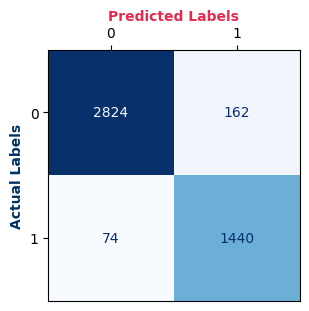

In [ ]:
plot_confusion_matrix(y_test, y_pred)

### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2986
           1       0.90      0.95      0.92      1514

    accuracy                           0.95      4500
   macro avg       0.94      0.95      0.94      4500
weighted avg       0.95      0.95      0.95      4500



### Visualize [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) and [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
> ❗ **Note**
+ This implementation of [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) is restricted to the binary classification task

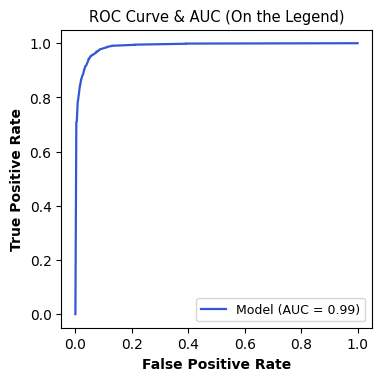

In [ ]:
plot_roc_curve(cat_model, X_test, y_test)

> 👏 **Bam!**  

> Everything looking much better this far!
+ `FN` have significantly reduced and `recall` significantly improved as well.
+ It's time we saved the model

## Save the model  
> Saving the model for inferencing

### Dump

In [ ]:
# import joblib
import joblib

filename = 'diabetes_model.pkl'
joblib.dump(cat_model, filename)

['diabetes_model.pkl']

### Use the model for inferencing  
> 📝 **Note**
+ The model accepts an array of feature arrays  
+ Hence, one can predict the classes of multiple patients in a single call

In [ ]:
# load the model
model = joblib.load(filename)

In [ ]:

X_new = np.array([[2,180,74,24,21,23.9091702,1.488172308,22]])

# turn the array into a dataframe
X_new = pd.DataFrame(X_new, columns=features)
X_new['Age'] = X_new['Age'].astype('int')

In [ ]:
# get a prediction
print(f'Predicted class is: {model.predict(X_new)[0]}')

Predicted class is: 1


> 🌱 **Future improvements**  

> A number of things can be done to refactor the code in future
+ Eliminate `dataframes` from the pre-processing `pipeline` and all workings of the model. Had me writing significantly more code. In the coming notebooks, I'll be working purely with `numpy.ndarray` instead  
+ Implement `ROC` curve tuning with [`TunedThresholdClassifierCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TunedThresholdClassifierCV.html#sklearn.model_selection.TunedThresholdClassifierCV). During the time of making this notebook, I got an error every time I tried importing the class! 😿💔
+ Work with `CatBoost` [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool) class to harness the power of `CatBoost` data processing

> ▶️ **Up Next**  

> There's no rest for the weary 💔
+ So we're starting on _multiclass classification_ in the next notebook